In [1]:
# importing all necessary libraries...
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
Data = pd.read_csv("./archive/creditcard.csv").astype('float32')

# preprocess Data
Data = Data.drop(['Time'], axis=1)
Data['Amount'] = StandardScaler().fit_transform(Data['Amount'].values.reshape(-1,1))

fraud = Data[Data['Class'] == 1]
nonFraud = Data[Data['Class'] == 0]

# seperate nonfraud data 
trainData, testData = train_test_split(nonFraud, train_size=0.9)

# add fraud data to testData
testData = pd.concat([fraud, testData])

# final preprocessing
trainData = trainData.drop(['Class'], axis=1)

# save both testData and trainData for future use
trainData.to_csv('./Dataset/trainingData', index=False)
testData.to_csv('./Dataset/testingData', index=False)

In [36]:
# load and shuffle dataset
testData = pd.read_csv('./Dataset/testingData').astype('float32')
testData = testData.sample(frac=1, random_state=42)

V1        28699
V2        28709
V3        28706
V4        28715
V5        28713
V6        28714
V7        28712
V8        28716
V9        28715
V10       28713
V11       28714
V12       28714
V13       28716
V14       28715
V15       28715
V16       28715
V17       28711
V18       28714
V19       28717
V20       28712
V21       28715
V22       28710
V23       28711
V24       28713
V25       28711
V26       28712
V27       28716
V28       28716
Amount     8978
Class         2
dtype: int64

In [44]:
fraudSample = testData[testData['Class'] == 1]
nfraudSample = testData[testData['Class'] == 0].sample(800)

sampleData = pd.concat([fraudSample, nfraudSample])
dataY = sampleData["Class"].values
dataX = sampleData.drop(["Class"], axis=1).values

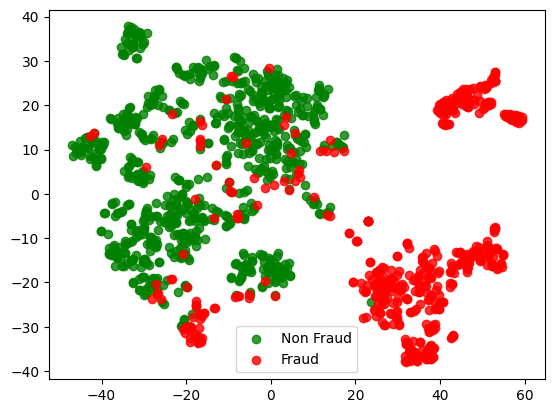

In [45]:
# helper function for TSNE visualization...
def tsne_plot(x1, y1):
    tsne = TSNE()
    X_t = tsne.fit_transform(x1)

    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
    plt.legend(loc='lower center')
    plt.show()
    
tsne_plot(dataX, dataY)

In [62]:
import tensorflow as tf
import tensorflow_probability as tfp

latent_dim = 2
input_shape = 29
tfd = tfp.distributions

def model():
    prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros(latent_dim))

    encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape, name='encoder_input'),
    tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(8, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim), activation="linear"),
    tfp.layers.MultivariateNormalTriL(latent_dim, 
                           activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)),
], name='encoder')

    decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[latent_dim]),
    tf.keras.layers.Dense(8, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(tfp.layers.IndependentNormal.params_size(input_shape), activation="linear"), 
    tfp.layers.IndependentNormal(input_shape),
], name='decoder')

    vae = tf.keras.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

    def negative_log_likelihood(x, rv_x):
        return -tf.reduce_sum(rv_x.log_prob(x), axis=-1)

    vae.compile(optimizer="adam", 
            loss=negative_log_likelihood)
    
    return vae

In [63]:
model = model()
model.load_weights("")